In [638]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib notebook

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# Часть 1

1. Пусть G - событие, сосотоящее в том, что подсудимый виновен, а В - событие, сосотоящее в том, что группа крови принадлежит редкой группе.
Прокурор оценил вероятность $p(B|\overline{G}) = 0.01$, откуда не следует, что $p(G|B) = 0.99$. Отсюда можно лишь сделать вывод, что $p(\overline{B}|\overline{G}) = 0.99$.

2. Для определения вероятности виновности необходимо оценить:

$$p(G|B) = \frac{p(B|G)p(G)}{p(B)} = \frac{p(B|G)p(G)}{p(B|G)p(G) + p(B|\overline{G})p(\overline{G})} $$
Мы знаем, что найденная кровь принадлежит убийце, соответственно $p(B|G) = 1$. Также прокурор уже оценил $p(B|\overline{G}) = 0.01$. Остаётся оценить априорные вероятности $p(G)$ и $p(\overline{G})$. Вместо этого адвокат оценил априорную вероятность $p(G|B)$.

3. Обозначим за x вероятность false negatives, а за y - вероятность false positives.
$$p1 = p(d=1|t=1) = \frac{p(t=1|d=1)p(d=1)}{p(t=1|d=1)p(d=1) + p(t=1|d=0)p(d=0)} = \frac{(1 - x)p(d=1)}{(1 - x)p(d=1) + yp(d=0)} = \frac{0.01(1 - x)}{0.01(1 - x) + 0.99y}$$
$$p2 = p(d=1|t=0) = \frac{p(t=0|d=1)p(d=1)}{p(t=0|d=1)p(d=1) + p(t=0|d=0)p(d=0)} = \frac{0.01x}{0.01x + 0.99(1-y)}$$
Построим графики:

<IPython.core.display.Javascript object>


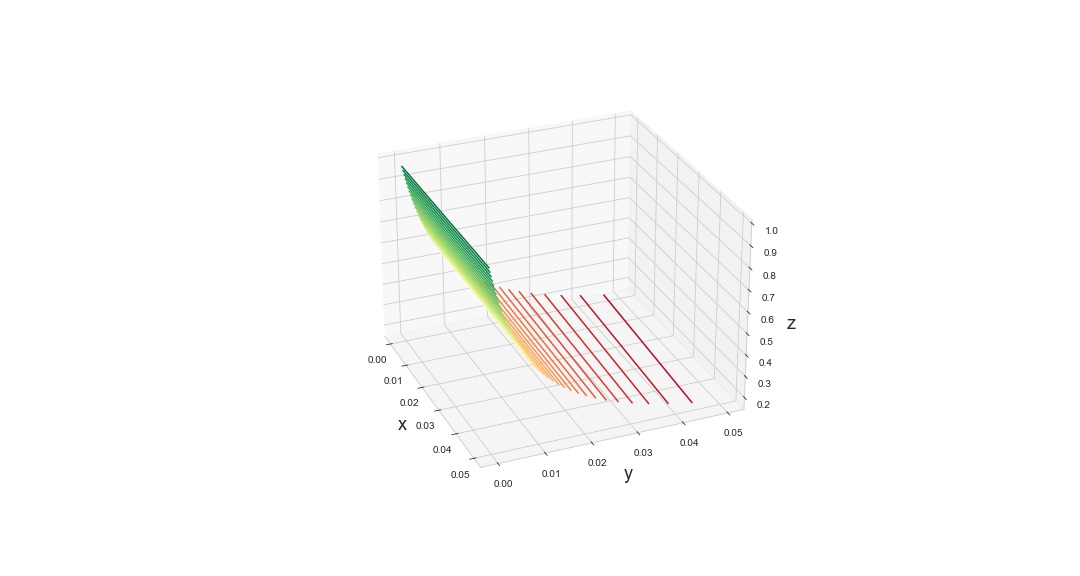

In [639]:
def get_p1(x, y):
    return 0.01*(1 - x) / (0.01 * (1 - x) + 0.99 * y)

def get_p2(x, y):
    return 0.01 * x / (0.01 * x + 0.99 * (1 - y))

x = np.linspace(0, 0.05, 500)
y = np.linspace(0, 0.05, 500)
X, Y = np.meshgrid(x, y)
p1 = get_p1(X, Y)
p2 = get_p2(X, Y)

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p1, 50, cmap='RdYlGn')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18);

<IPython.core.display.Javascript object>


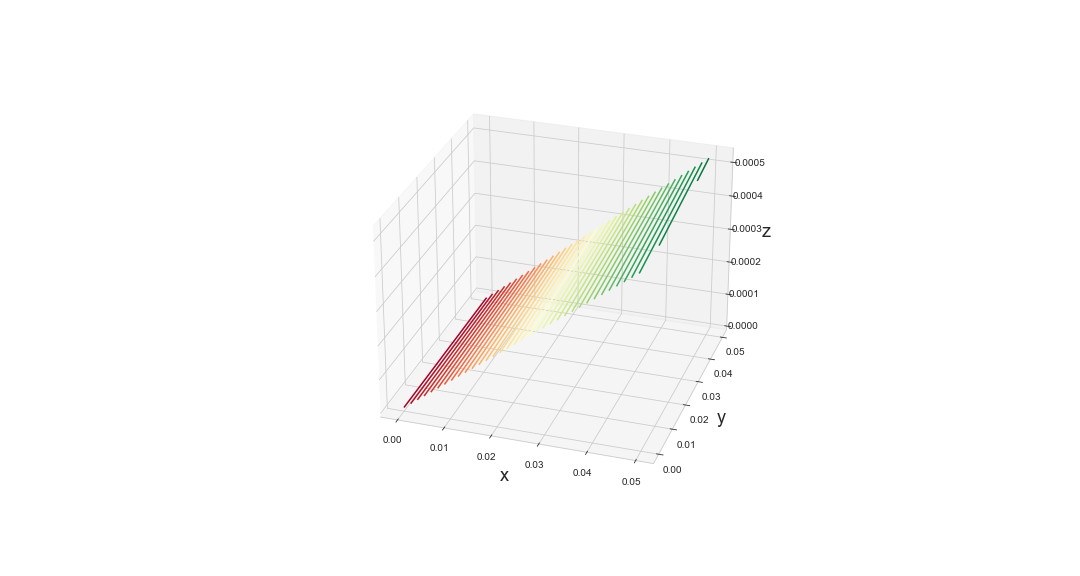

In [640]:
fig = plt.figure(figsize=figsize)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p2, 50, cmap='RdYlGn')
ax.set_xlabel('x', fontsize=18)
ax.set_ylabel('y', fontsize=18)
ax.set_zlabel('z', fontsize=18);

Для медицинского теста гораздо важнее снизить вероятность $p(d=1|t=0)$, чем повысить вероятность $p(d=1|t=1)$, а $p(d=1|t=0)$ растёт быстрее по x, чем по y. Таким образом, более правильным решением будет уменьшать число false negatives.

# Часть 2

## Задание 1

Готовим данные

In [601]:
data = pd.read_csv('owid-covid-data.csv')

In [602]:
data_russia = data[data['location'] == 'Russia']

In [603]:
start_date = datetime.strptime('2020-03-02', '%Y-%m-%d')

In [604]:
start_date

datetime.datetime(2020, 3, 2, 0, 0)

In [605]:
data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)

<ipython-input-605-0f16b0453dc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)


In [606]:
data_russia = data_russia[data_russia['days'] > 0]

In [607]:
data_russia['new_cases'] = data_russia['new_cases'].transform(lambda x: 1 if x == 0 else x)

In [608]:
train_data_russia = data_russia[data_russia['days'] <= 50]
test_data_russia = data_russia[data_russia['days'] > 50]

## Задание 2

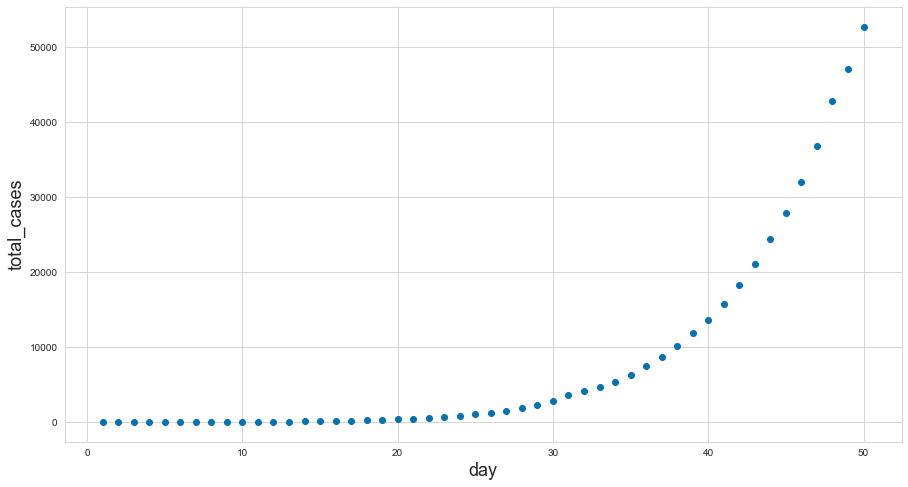

In [610]:
%matplotlib inline
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('total_cases', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

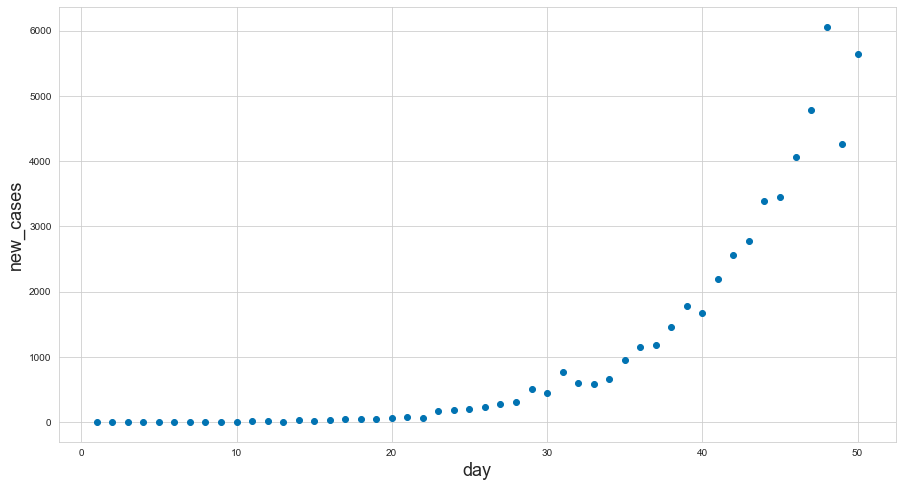

In [611]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('new_cases', fontsize=18)
ax.set_xlabel('day', fontsize=18)
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy())
plt.show()

### 2.a

Для обучения модели в предположении экспоненциальности роста числа заболевших прологарифмируем целевую переменную

In [612]:
train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))

<ipython-input-612-72c8d764991b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))


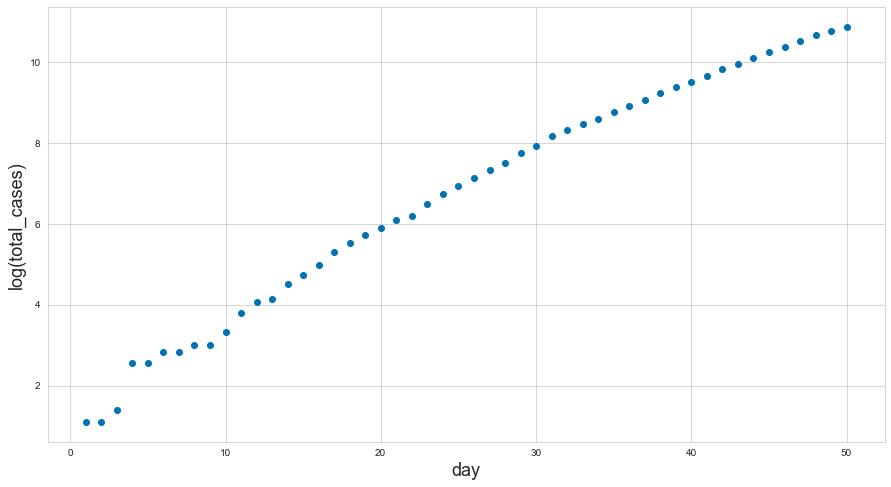

In [614]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(total_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

Как мы видим после логарифмирования зависимости целевых переменных от дней стали квазилинейными. Таким образом, можно попытаться обучить линейную модель.

In [615]:
exp_model = LinearRegression()
exp_model.fit(train_data_russia['days'].to_numpy().reshape(-1, 1), train_data_russia['total_cases'])

LinearRegression()

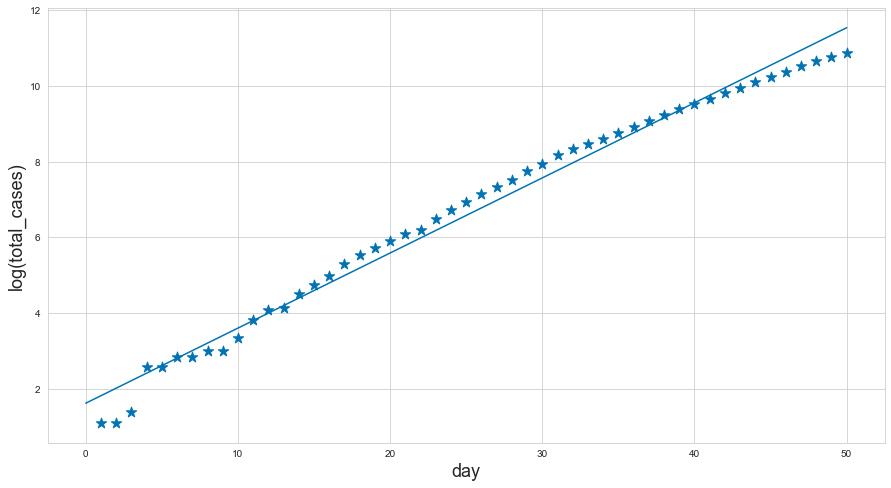

In [616]:
def predicted_curve(x):
    return x * exp_model.coef_ + exp_model.intercept_

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(total_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.plot([0] + list(train_data_russia['days'].to_numpy()), predicted_curve([0] + list(train_data_russia['days'].to_numpy())))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 2.b

Оценим дисперсию шума в данных исходя из параметров полученной модели:

In [617]:
def get_disp(X, Y, w0, w1):
    return np.sum((Y - w0 - X * w1)**2) / len(X)

In [618]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), exp_model.intercept_, exp_model.coef_)

In [619]:
sigma = math.sqrt(disp)

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [620]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [621]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [625]:
def plot_w_space_heatmap(X, Y, sigma, w0_lim=[-1, 1], w1_lim=[-1, 1]):
    w0 = np.linspace(w0_lim[0], w0_lim[1], 1000)
    w1 = np.linspace(w1_lim[0], w1_lim[1], 1000)
    w0, w1 = np.meshgrid(w0, w1)
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim((w1_lim[0], w1_lim[1]))
    ax.set_xlim((w0_lim[0], w0_lim[1]))
    ax.set_ylabel('W1', fontsize=18)
    ax.set_xlabel('W0', fontsize=18)
    p = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    ax.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


In [626]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma)

<ipython-input-625-e1c15be0fac4>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


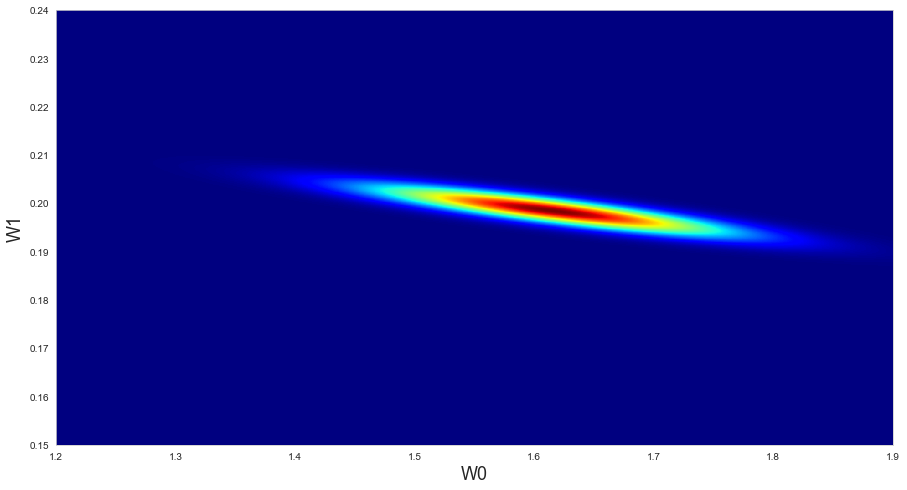

In [627]:
plot_w_space_heatmap(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma, [1.2, 1.9], [0.15, 0.24])

### 2.c

In [628]:
def plot_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60), math.exp(w[0] + w[1]*91), math.exp(w[0] + w[1]*183))
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

In [629]:
def plot_new_cases_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs) - np.exp(w[0] + w[1]*(xs - 1)), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60) - math.exp(w[0] + w[1]*59),
              math.exp(w[0] + w[1]*91) - math.exp(w[0] + w[1]*90),
              math.exp(w[0] + w[1]*183) - math.exp(w[0] + w[1]*182))
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

715055.8836895241 328296644.42503357 2.6072172811883172e+16
708001.4284633556 307819926.72420496 2.0795974442205324e+16
927663.3260817378 550690593.8373444 9.375429488546195e+16
853408.1884960792 454254043.050469 5.594802037294307e+16
691388.7167653788 291843443.4127584 1.80609955494302e+16
860778.3646601486 465487389.85725635 6.008911786745609e+16
699394.4112760565 292547439.9596772 1.7621994165259646e+16
650792.8773327701 253792230.74419716 1.241661249234639e+16
742126.1803831945 353724330.82496756 3.139303770695441e+16
774585.2109590844 381113362.7379411 3.716814427777472e+16
724575.647654843 339219967.14333487 2.8545165773308532e+16
792643.0287687712 383670820.4406571 3.5644545493310796e+16
819491.585419837 414394837.06946707 4.3833105450865256e+16
713106.2027573673 328720537.4777545 2.6419207620808596e+16
755325.8157261326 357259615.7346434 3.099183213155463e+16
978144.256327879 588864033.7652335 1.0451689134099138e+17
818129.1740342039 389411999.7667701 3.441897185823419e+16
7410

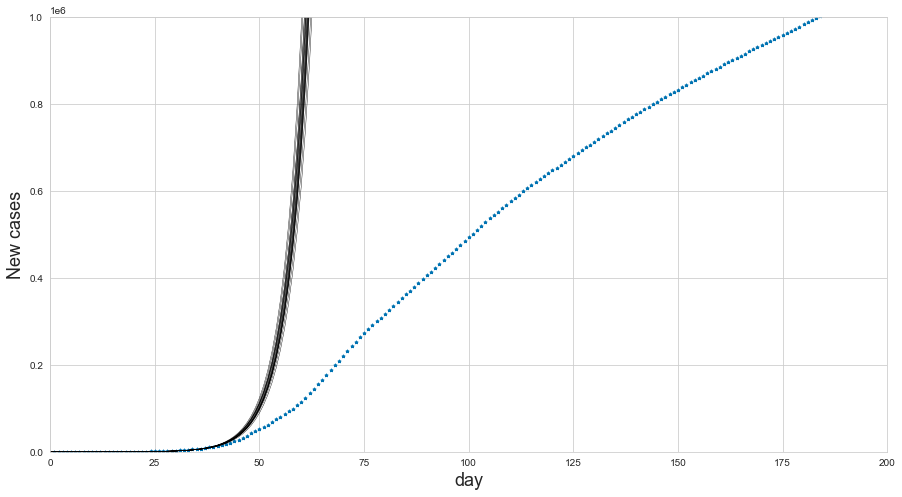

In [630]:
plot_sample_exponents(sigma, 20, xlim=(0, 200), ylim=(0, 1000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

Полученная модель предсказывает более 600000 случаев заражения к 1 мая, более 200000000 к 1 июня и более 10^16 к 1 сентября, что, как мы видим, на деле оказалось не так. С новыми случаями заражения ситуация идентичная:

123276.52681032964 54469822.49080902 3860567938989896.0
154901.66819853615 75257854.05031991 7069323961671456.0
153153.0566605936 81236599.3095389 9902361325058728.0
140583.5978781156 65962065.61811948 5587276158094992.0
130387.8744880656 56299023.07892859 3726347163716510.0
131087.4697502217 57397075.76589182 3959782908327668.0
135163.97651689325 64724530.26066744 5824175154880192.0
121909.53304645349 54474360.46702799 3991780974395928.0
110616.05881348974 44714461.60703671 2433619341590130.0
155115.61262983654 81869671.66570932 9833409472526536.0
160387.96259589482 84310859.41103142 1.0005847009354416e+16
122722.16188081051 50926595.26112321 2996106627929604.0
163846.0447084756 87919165.63271862 1.1091063654531896e+16
93709.98974473105 34457152.90301338 1415800412086470.0
144186.50722532358 73028993.77420533 7761813195900456.0
162633.54616492288 90223927.6556946 1.256425644042424e+16
144680.07670978399 73259824.96078831 7780307511363052.0
123831.98892009573 53643212.48863533 35851415

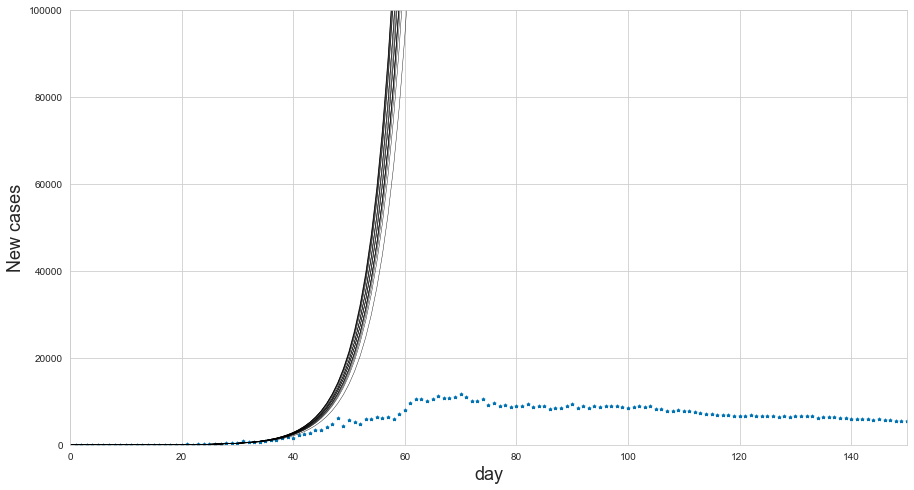

In [631]:
plot_new_cases_sample_exponents(sigma, 20, xlim=(0, 150), ylim=(0, 100000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения

In [632]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [633]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] - sigma), np.exp(mu[1]*days_arr + mu[0] + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

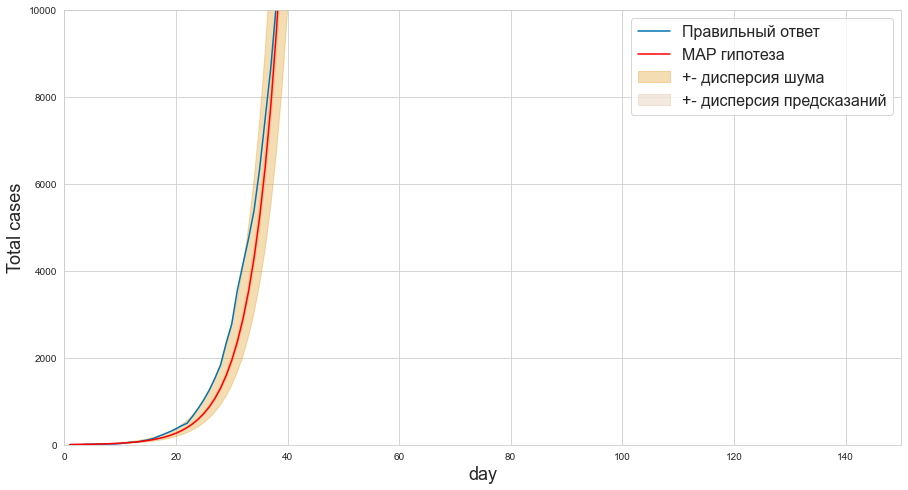

In [634]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred)

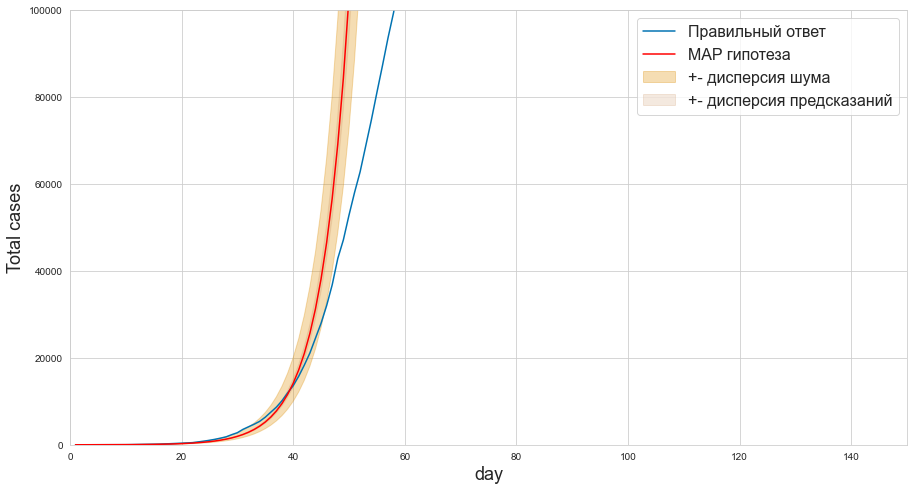

In [635]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 150), ylim=(0, 100000))

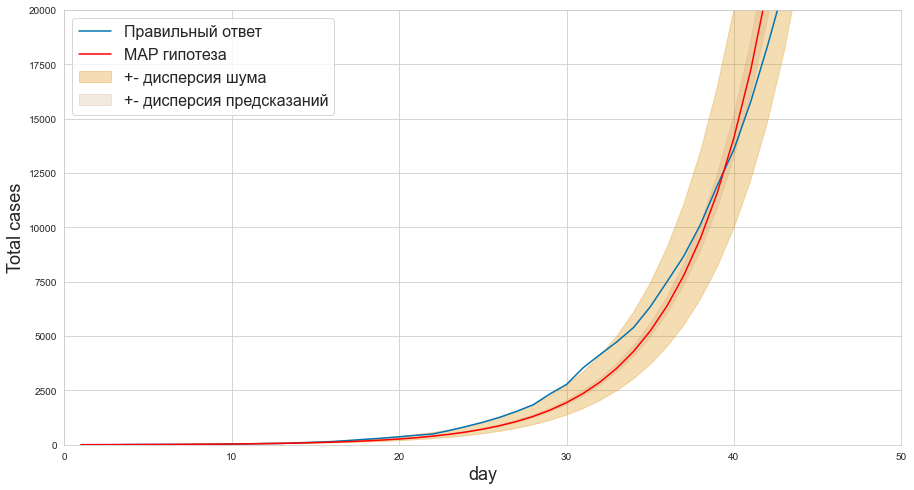

In [636]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 50), ylim=(0, 20000))

## Задание 3

### 3.a

Возьмем производную от Ф(x) ("физический смысл" - скорость прироста случаев) и в качестве целевой переменной возьмём new_cases. Тогда $ln(y) \propto w_0 + w_1 x + w_2 x^2$

Логарифмируем целевую переменную:

In [491]:
train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))

<ipython-input-491-b1987e1897a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))


In [492]:
train_data_new = pd.DataFrame()
train_data_new['days'] = train_data_russia['days']
train_data_new['days_2'] = train_data_new['days']**2

Обучаем модель:

In [493]:
probit_model = LinearRegression()
probit_model.fit(train_data_new, train_data_russia['new_cases'])

LinearRegression()

In [494]:
probit_model.coef_

array([ 0.27928241, -0.00182979])

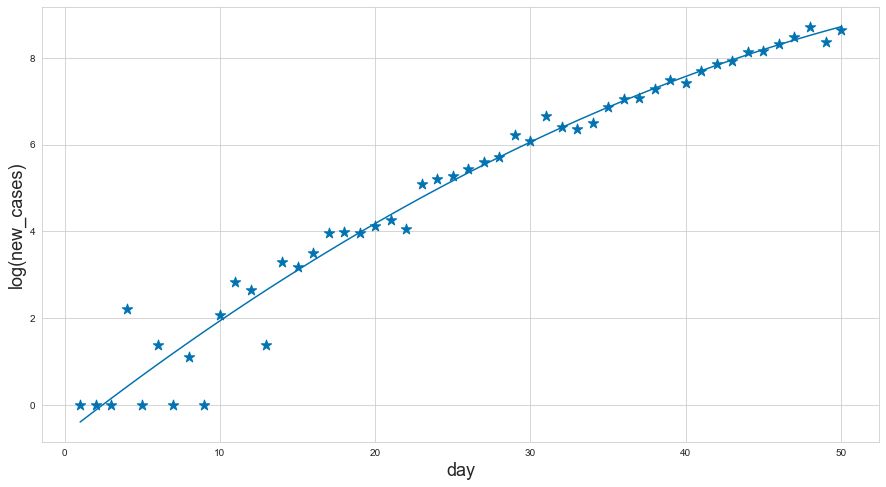

In [582]:
def predicted_curve(x):
    return probit_model.intercept_ + x * probit_model.coef_[0] + x**2 * probit_model.coef_[1]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(new_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.plot(train_data_russia['days'].to_numpy(), predicted_curve(train_data_russia['days'].to_numpy()))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 3.b

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [534]:
def get_disp(X, Y, w0, w1, w2):
    return np.sum((Y - w0 - X * w1 - X**2 * w2)**2) / len(X)

In [535]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), exp_model.intercept_, probit_model.coef_[0], probit_model.coef_[1])

In [536]:
sigma = math.sqrt(disp)

In [537]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [538]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[5, 0, 0], [0, 5, 0], [0, 0, 5]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [539]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), sigma)

### 3.c

In [580]:
def plot_sample_sigmoids(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    cases_num = [[], [], []]
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for w in my_w:
        ax.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
        cases_num[0].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[60])
        cases_num[1].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[91])
        cases_num[2].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[183])
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)
    return cases_num

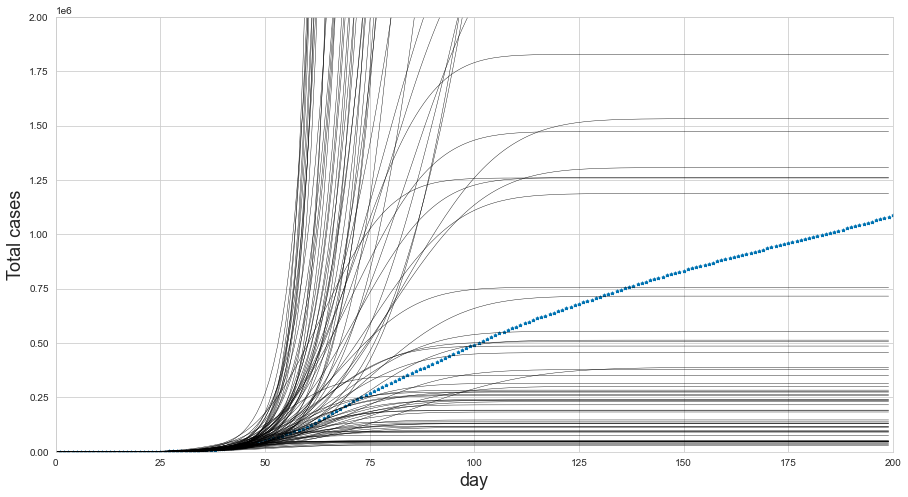

In [581]:
cases_num = plot_sample_sigmoids(sigma, 100, xlim=(0, 200), ylim=(0, 2000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

In [542]:
for i in range(3):
    print(np.percentile(cases_num[i], 10), np.percentile(cases_num[i], 90))

55176.741651636825 1053163.452496401
70206.18806312757 1635741682.5066628
70210.34707127037 2.0406316223489045e+22


Из полученных результатов можно сделать вывод, что в оптимистичном сценарии в России будет порядка 70000 случаев, в пессимистичном сценарии переболеют все.

In [576]:
def plot_new_cases(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs + w[2]*xs**2), 'k-', lw=.4)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

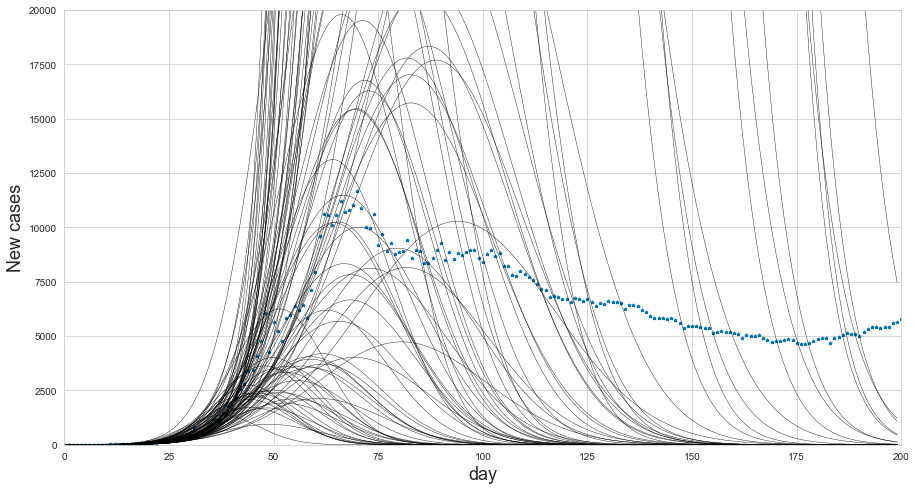

In [577]:
plot_new_cases(sigma, 100, xlim=(0, 200), ylim=(0, 20000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения:

In [545]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs**2
    return res

In [567]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2)), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma)), np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma)), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.cumsum(np.mean(np.exp(predictions), axis=0)) - np.cumsum(np.std(np.exp(predictions), axis=0)), np.cumsum(np.mean(np.exp(predictions), axis=0)) + np.cumsum(np.std(np.exp(predictions), axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


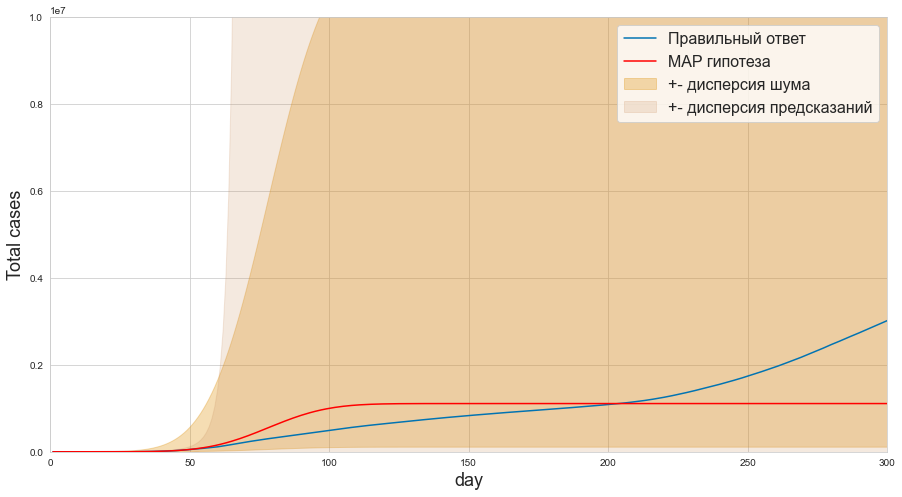

In [568]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 10000000))

C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


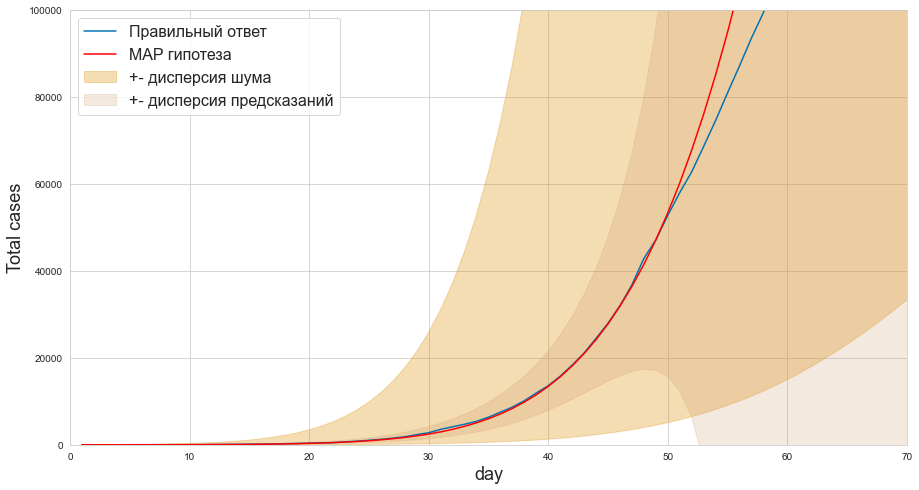

In [569]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 70), ylim=(0, 100000))

In [570]:
def plot_new_cases_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma), np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


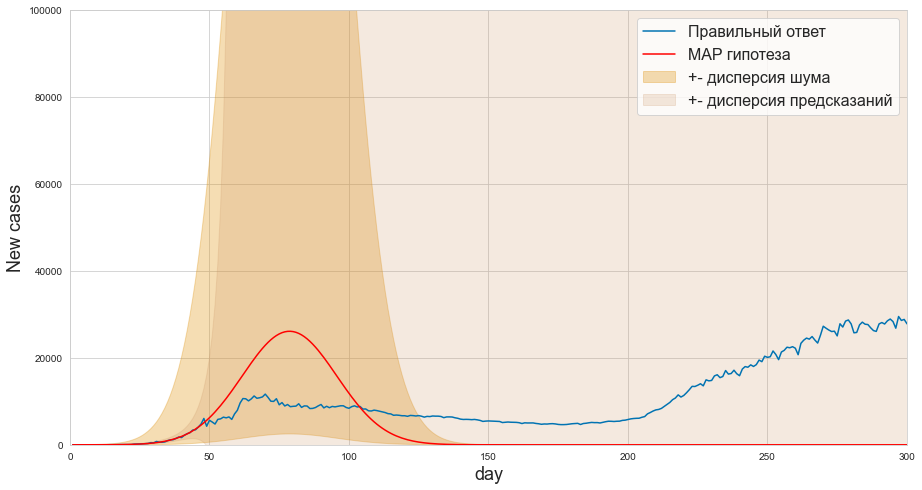

In [571]:
plot_new_cases_predictions(data_russia['days'].to_numpy(), data_russia['new_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 100000))